Topics to be covered:

1. Text Generation\
    1.1 Using GPT to generate text\
    1.2 Calculating the text generation loss
2. Text Evaluation
3. Training & Validation Losses
4. Training the LLM
5. Strategies to control randomness in text generation\
    5.1 Temperature scaling\
    5.2 Top-k sampling
6. Loading and saving model weights in PyTorch
7. Loading pretrained weights from OpenAI

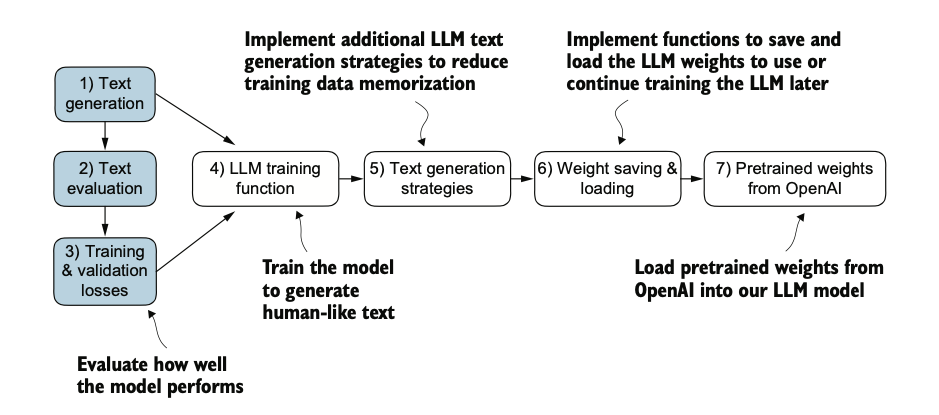

# 1. Text Generation

## 1.1 Using GPT to generate text

In [53]:
import torch
from chapter4 import GPTModel

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, # was previously 1024
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (token_embed): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Li

#### Using the GPTModel instance, we adopt the generate_text function from chapter 4 and introduce two handy functions: text_to_token_ids and token_ids_to_text. These functions facilitate the conversion between text and token representations, a technique we will utilize throughout this chapter.

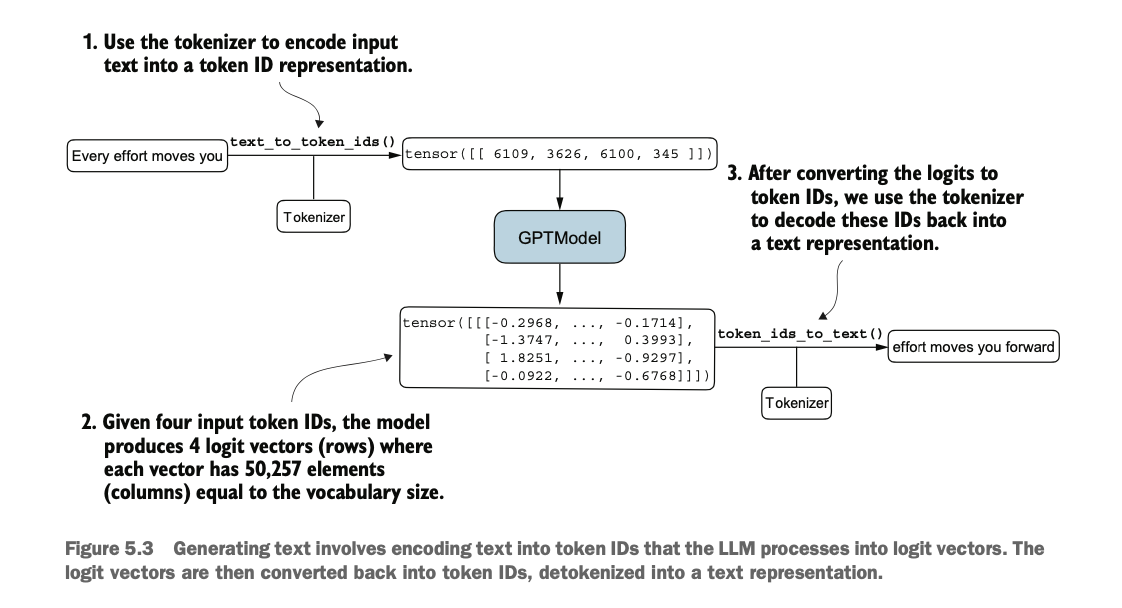

In [54]:
import tiktoken

In [ ]:
# generate_text from chapter 4
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [52]:
# utility functions for text to token ID and vice versa conversions
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # adding batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flatten = token_ids.squeeze(0) # removing batch dimension
    return tokenizer.decode(flatten.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding('gpt2')

# starting text gets fed to text_to_token_ids for encoding, and that gets fed to generate_text_simple to
# generate the remaining tokens
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

decoded_and_generated = token_ids_to_text(token_ids, tokenizer)

print(f"Token IDs for the inputted text (i.e. 'start_context'):\n{text_to_token_ids(start_context, tokenizer)}\n\nGenerated token IDs based on the inputted text and context length:\n{token_ids}\n\nOutput text via decoding the generated token IDs:\n{decoded_and_generated}")

NameError: name 'tiktoken' is not defined

## 1.2 Calculating the text generation loss

Le's consider the following two examples. 

In [5]:
inputs = torch.tensor([[16833, 3626, 6100], # "every effort moves"
                        [40, 1107, 588]]) # "I really like"

matching these inputs, creating targets we want the model to produce (these are inputs that are basically shifted by one position to the right).

In [6]:
targets = torch.tensor([[3626, 6100, 345 ], # " effort moves you"
                        [1107, 588, 11311]]) # " really like chocolate"

targets are basically $ y $ values that we want the model to produce. In other words, we will compare what the model generates (aka ŷ) with the $ y $ values.

Symbolically (in a very loose sense):

$$ loss = y - ŷ $$

where $ y $ is the target and ŷ is the model's output.

In [7]:
# calculating our ŷ

with torch.no_grad(): # diasbling gradient tracking as this isn't yet the training stage
    logits = model(inputs)
probabilities = torch.softmax(logits, dim=-1)
print(f"Probabilities:\n{probabilities}\n\nProbabilities' shape: {probabilities.shape}")

Probabilities:
tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0538e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
          5.8203e-05, 1.3698e-05]]])

Probabilities' shape: torch.Size([2, 3, 50257])


In [8]:
token_ids = torch.argmax(probabilities, dim=-1, keepdim=True)
token_ids

tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])

In [9]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}") # for the 1st batch
print(f"Outputs batch 1:"
f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


It can be seen that the model, at this stage, produces random gibberish. This is because the model has not been trained yet.

Now, as the text generation part is done, it's time to move on to the text evaluation part.

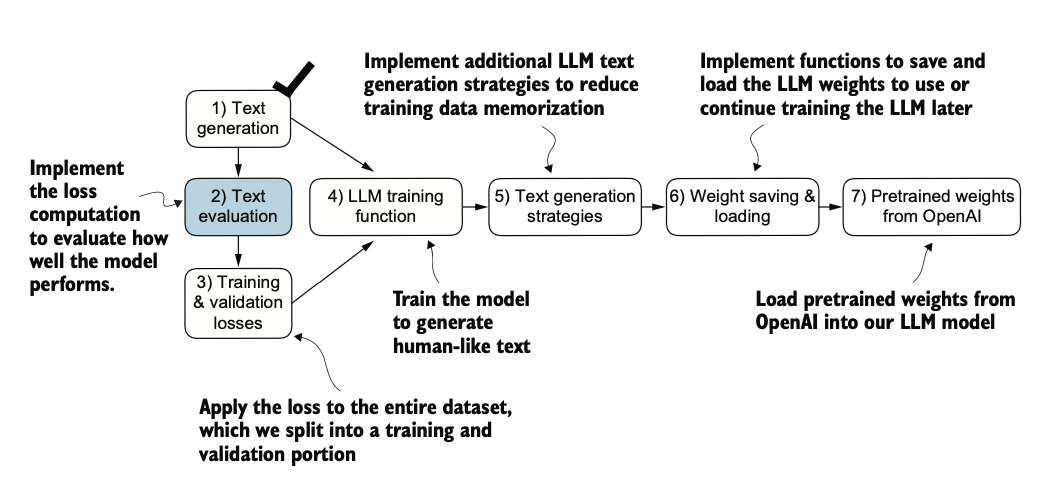

---

# 2. Text Evaluation

For each of the two input texts, printing the initial softmax probability scores corresponding to the target tokens:

In [10]:
probabilities = torch.softmax(logits, dim=-1)
print(probabilities, probabilities.shape)
print("All probabilities ↑\n")

text_idx = 0
target_probas_1 = probabilities[text_idx, [0, 1, 2], [3626, 6100, 345]]
print("\nText 1:", target_probas_1)

tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0538e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
          5.8203e-05, 1.3698e-05]]]) torch.Size([2, 3, 50257])
All probabilities ↑


Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])


In [11]:
text_idx = 1
target_probas_2 = probabilities[text_idx, [0, 1, 2], [1107, 588, 11311]]
print("Text 2:", target_probas_2)

Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [12]:
# Therefore, the three target token ID probabilities for each batch are:
print(f"Text 1: {target_probas_1}\nText 2: {target_probas_2}")

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


Now calculating the loss for the probability scores of these two example batches.

Firstly, calculating the negative average log probability of the target tokens:

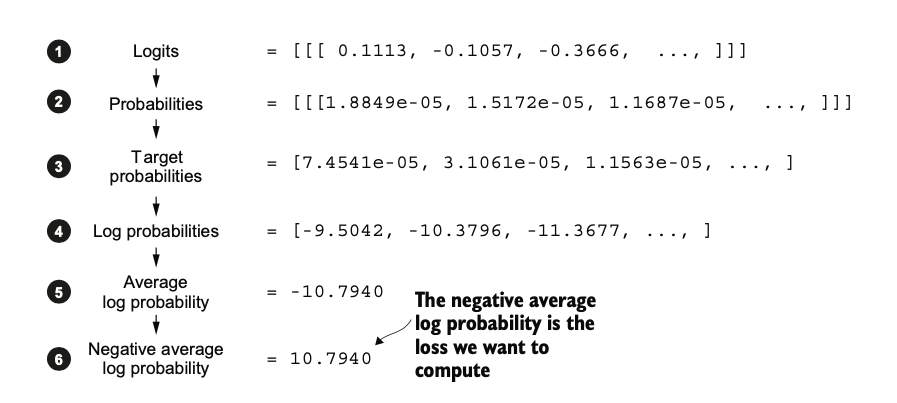

In [13]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [14]:
neg_avg_log_probas = -torch.mean(log_probas)
neg_avg_log_probas

tensor(10.7940)

#### NOTE

In deep learning, the term for turning this negative value, –10.7940, into 10.7940, is known as the cross entropy loss. Instead of doing these step-by-step calculations, we can use the `cross_entropy` function like this:

``` python
import torch.nn.functional as F
loss = F.cross_entropy(input, target)
```

Let's apply this to the two examples:

In [15]:
inputs = torch.tensor([[16833, 3626, 6100], # "every effort moves"
                        [40, 1107, 588]]) # "I really like"

targets = torch.tensor([[3626, 6100, 345 ], # " effort moves you"
                        [1107, 588, 11311]]) # " really like chocolate"

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

with torch.no_grad(): # diasbling gradient tracking as this isn't yet the training stage
    logits = model(inputs)
# probabilities = torch.softmax(logits, dim=-1)

In [16]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [17]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print(f"Flattened logits: {logits_flat.shape}\nFlattened targets: {targets_flat.shape}")

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [18]:
import torch.nn.functional as F

loss = F.cross_entropy(logits_flat, targets_flat)
print("Loss:", loss)

perplexity = torch.exp(loss)
print("Perplexity:", perplexity)

Loss: tensor(10.7940)
Perplexity: tensor(48725.8203)


#### ↑ What is happening here?
Perplexity is often considered more interpretable than the raw loss value because it signifies the effective vocabulary size about which the model is uncertain at each step. In the given example, this would translate to **the model being unsure about which among 48,725 tokens in the vocabulary to generate as the next token**.

---

## 3. Calculating the Training & Validation Set Losses

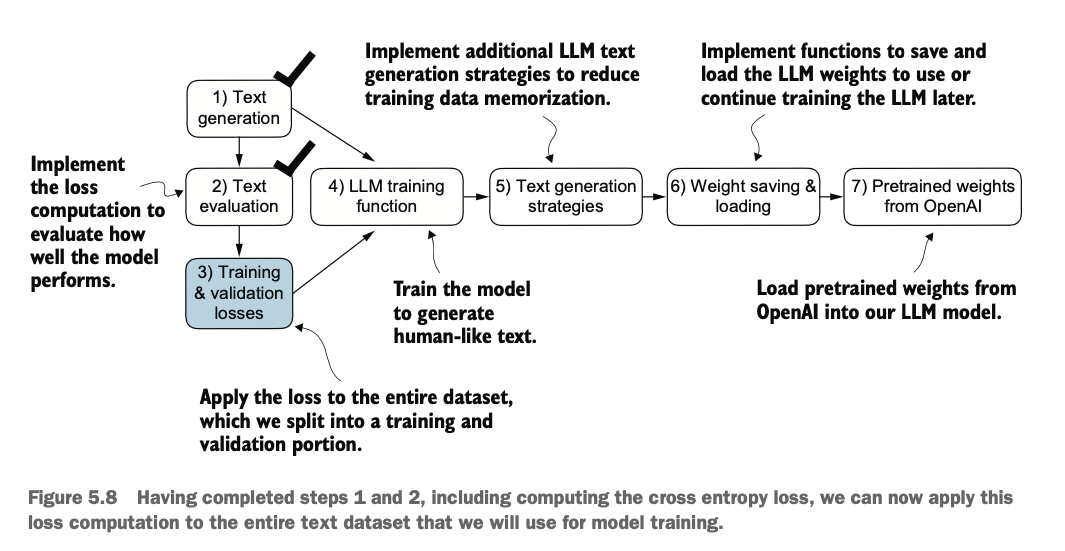

#### To compute the loss on the training and validation datasets, I'm gonna use the "The Verdict" short story.

In [76]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [20]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(f"Total characters: {total_characters}\nTotal tokens in the dataset: {total_tokens}")

Total characters: 20479
Total tokens in the dataset: 5145


#### Next, dividing the dataset into training and validation sets, plus using the data loaders from chap 2 to prepare the batches for LLM training.

using max_length = 6 here, but for the actual data loaders, we set max_length = 256-token context length so that the model sees longer texts during training.

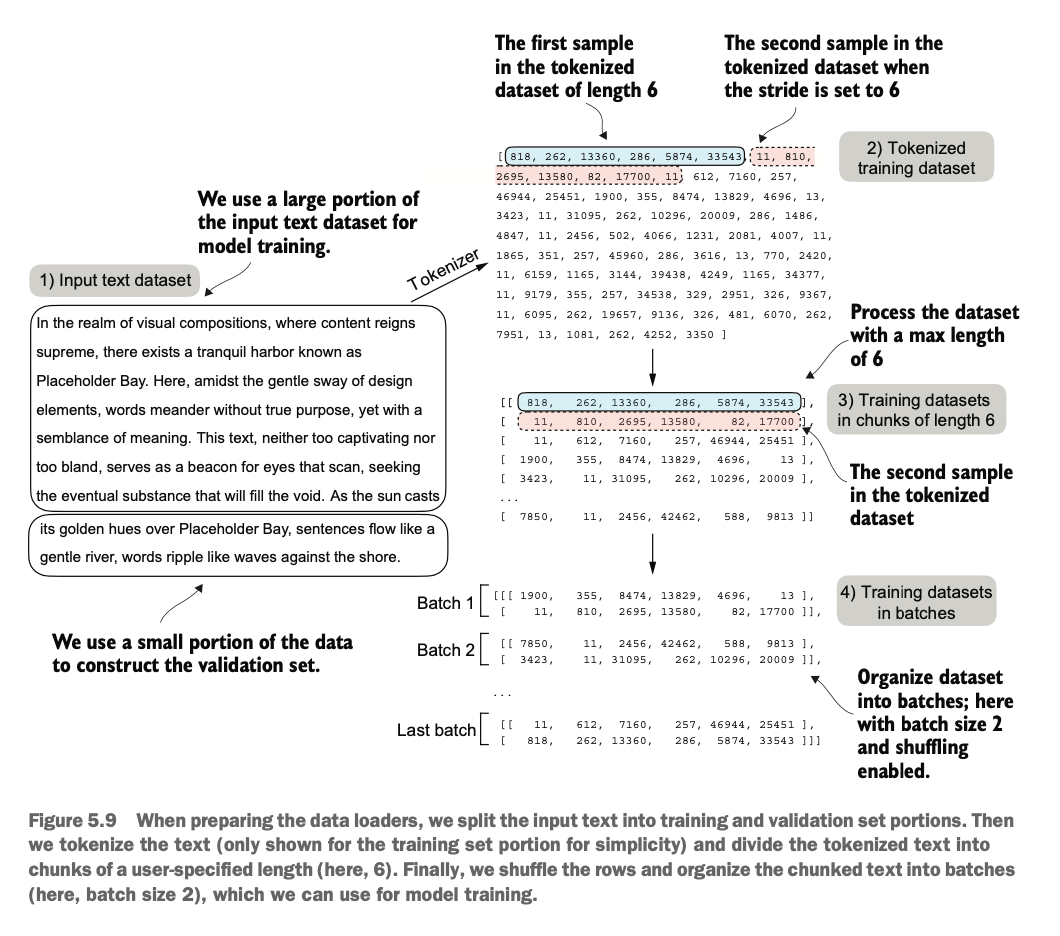

#### Now implementing data splitting and loading with a 90-10 split (90% training and 10% validation):

In [77]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print(len(train_data), len(val_data))
print((len(train_data) + len(val_data)) - len(text_data))

18431 2048
0


In [78]:
from chapter2 import create_dataloader_v1
torch.manual_seed(123)

In [79]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    drop_last=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    drop_last=True,
    num_workers=0    
)

In [24]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("----------------------------------\n\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
----------------------------------

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


#### ↑ What is happening here?

I can see nine training set batches with two samples and 256 tokens each. Since we allocated only 10% of the data for validation, there is only one validation batch consisting of two input examples. As expected, the input data (x) and target data (y) have the same shape (the batch size times the number of tokens in each batch) since the targets are the inputs shifted by one position.

#### Implementing a utility function to calculate the cross-entropy loss of a given batch returned via the training and validation data loaders:

In [70]:
import torch.nn.functional as F

# this computes the loss for a single batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = F.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )
    return loss

# this calculates the loss across all the batches in a given data loader
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0 # starting point
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader) # iterates over all batches if no fixed num_batches specified
    else:
        # if num_batches > len(data_loader), reduce the num_batches to match len(data_loader) so that it still works
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches # averaging the loss over all the batches

In [26]:
# seeing all this in action

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.981106758117676


Relatively high loss. But this is to be expected since the model has not been trained yet.

---

# 4. Training the LLM

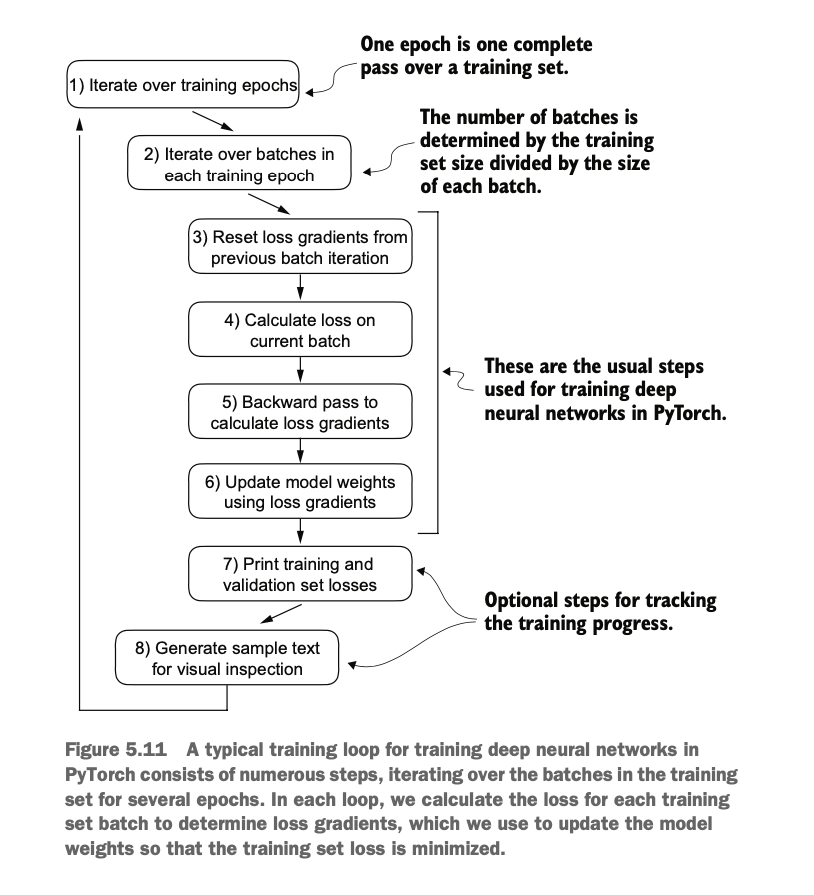

#### Main function for pretraining the LLM

In [31]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # disabling dropout for stable reproducible results
    with torch.no_grad(): # disables gradient tracking since this is eval
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

# ============= model training function ↓ ===============

def train_model_simple(model, train_loader, val_loader, optimizer, device,
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # epoch loop
    for epoch in range(num_epochs):
        model.train()

        # batch loop
        for input_batch, target_batch in train_loader:
            # zero grad
            optimizer.zero_grad()
            
            # loss calculation on current batch
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )

            # backprop to calculate loss gradients
            loss.backward()

            # update the weights based on these loss gradients
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            # evaluation (prints the things that happen one-by-one during the training)
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"""Ep {epoch+1} (Step {global_step:06d}): 
                      Train loss {train_loss:.3f}, 
                      Val loss {val_loss:.3f}""")
            
            # printing a sample text after each token
            generate_and_print_sample(
                model, tokenizer, device, start_context
            )
    return train_losses, val_losses, track_tokens_seen

#### Training my model for 10 epochs using AdamW optimizer and the function I just defined:

In [32]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay=0.1)
num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs,
    eval_freq=5, eval_iter=5, start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): 
                      Train loss 9.783, 
                      Val loss 9.927
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Every effort moves you,.                                                
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Ep 1 (Step 000005): 
                      Train loss 8.050, 
                      Val loss 8.333
Every effort moves you, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Every effort moves you, the,, the the the the the the the the the the the the the, the the the the the the, the the the the the the the the the the the the the the the the the the the the the the the the the
Eve

#### Visualizing all this

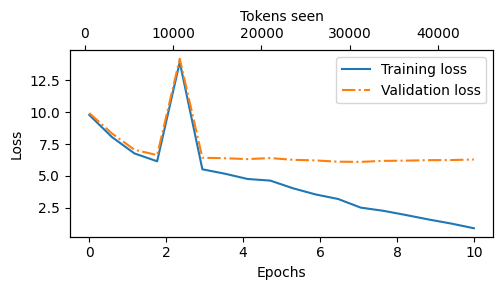

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss" )
    
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

This shows that the validation loss plateaus after the second epoch, while the training loss continues to decrease. The losses diverging is a clear sign of overfitting, which is expected given the small dataset size. The model is memorizing the training data instead of learning the underlying patterns.

This memorization is expected since this is a very small training dataset and I also trained it for multiple epochs. Usually, it's common to train a LLM on a much larger dataset for only 1 epoch.

---

# 5. Strategies to Control Randomness

Let's change the `generate_text_simple` function to include some few parameters to control the randomness of the generated text, such as `temperature scaling` and `top_k sampling`.

In [35]:
model.to("cpu")
model.eval()

GPTModel(
  (token_embed): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Li

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model, idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25, context_size=GPT_CONFIG_124M["context_length"]
)

print(f"Output text:\n{token_ids_to_text(token_ids, tokenizer)}")

NameError: name 'generate_text_simple' is not defined

#### ↑ What is happening here?

The generated token is selected at each generation step corresponding to the largest probability score among all tokens in the vocabulary. This means that the LLM will always generate the same outputs even if I run the preceding `generate_text_simple` function multiple times on the same start context (`Every effort moves you`).

## 5.1 Temperature Scaling

basically replacing the argmax function (which always selects the token with the highest probability, we often refer to this as greedy decoding) with a function that samples from the probability distribution. This function is called `torch.multinomial`.

`torch.multinomial` basically samples from a categorical distribution, which is a generalization of the Bernoulli distribution. In the Bernoulli distribution, there are only two possible outcomes (0 or 1), whereas in the categorical distribution, there are multiple possible outcomes. To be more comprehensive, the categorical distribution is a generalization of the Bernoulli distribution to more than two outcomes.

In [41]:
# doing a small example

vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

In [43]:
inverse_vocab = {idx: token for token, idx in vocab.items()}

In [44]:
# assuming the LLM is given the start context "every effort moves you" and
# generates the following next-token logits:

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [52]:
probas = torch.softmax(next_token_logits, dim=0)

# with argmax
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [67]:
# with torch.multinomial

next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


↑ mostly still 'forward', but sometimes also generates 'towards'. In other words, "forward" is still the most likely token and will be selected by multinomial most of the time but not all the time. Implementing a function that repeats this sampling 1,000 times to illustrate this:

In [92]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    # print("Sample: ", sample)
    sampled_ids = torch.bincount(torch.tensor(sample))
    print("sampled_ids:", sampled_ids)
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

sampled_ids: tensor([153,  68,  55, 223, 102,  50,  43, 218,  88])
153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


`torch.bincount` basically counts the number of occurrences of each element in the tensor. This is useful for counting the number of times each token was sampled.

↑ Here, the multinomial function allows me to sometimes generate slightly different tokens, such as "towards" instead of "forward". 

I can further control the randomness of the generated text by using the `temperature` parameter. The temperature parameter scales the logits before applying the softmax function. A higher temperature value (particularly greater than 1) will result in a more uniform distribution, while a lower temperature value (smaller than 1) will result in a sharper distribution (i.e., the model will be more confident about its predictions).

In [93]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

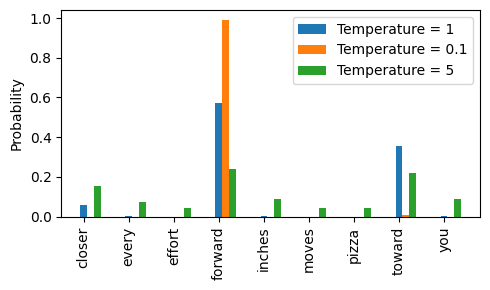

In [94]:
temperatures = [1, 0.1, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

x = torch.arange(len(vocab)) # creating a sample

bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

#### ↑ What is happening here?

The temperature of 1 is the same as not using temperature scaling at all since the logits are divided by 1. The temperature of 0.1 results in a much sharper distribution, with the model being more confident about its predictions. The temperature of 5 results in a much more uniform distribution, with the model being less confident about its predictions.

##### Printing the generated text with different temperature values:

In [98]:
for i, probas in enumerate(scaled_probas):
    print(f"Temperature: {temperatures[i]}")
    print_sampled_tokens(probas)
    print("\n")

Temperature: 1
sampled_ids: tensor([ 71,   2,   0, 544,   2,   1,   0, 376,   4])
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


Temperature: 0.1
sampled_ids: tensor([  0,   0,   0, 992,   0,   0,   0,   8])
0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


Temperature: 5
sampled_ids: tensor([153,  68,  55, 223, 102,  50,  43, 218,  88])
153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you




## 5.2 Top-k Sampling

Top-k sampling, when combined with probabilistic sampling and temperature scaling, can improve the text generation results. In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens and exclude all other tokens from the selection process by masking their probability scores.

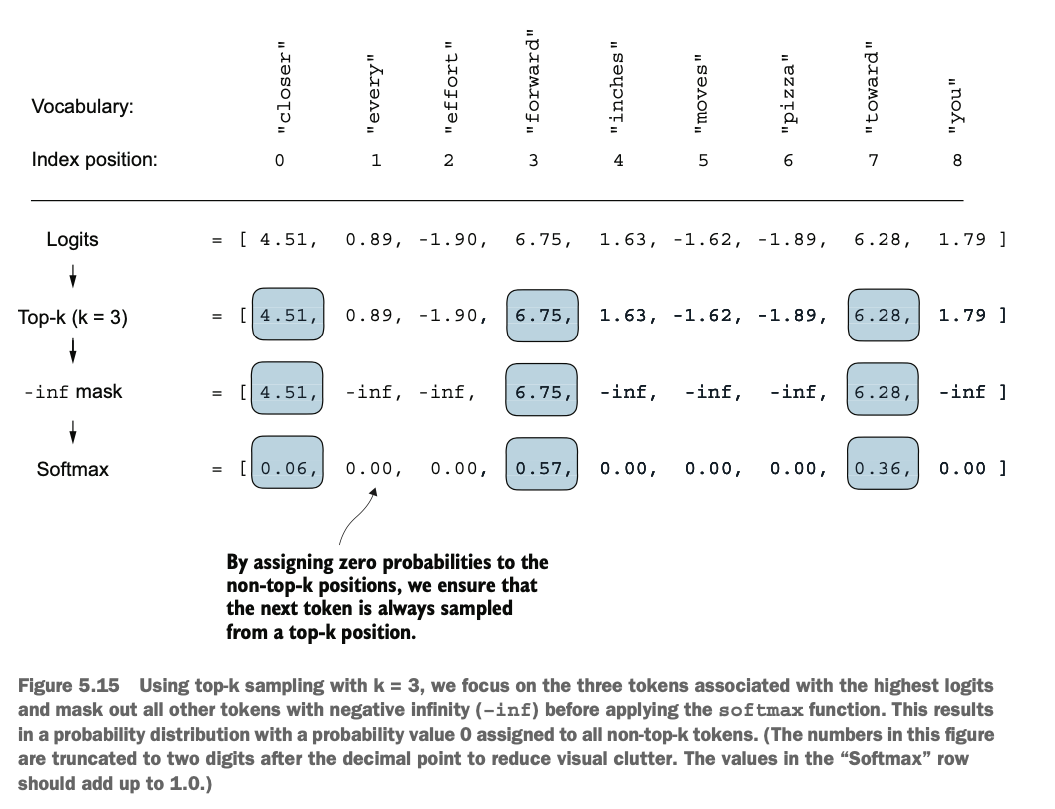

The implementation can be done as follows:

In [99]:
next_token_logits

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])

In [104]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print(f"Top logits: {top_logits}\nTop positions: {top_pos}")

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [113]:
# setting all the logit values below what I want to -inf for masking (similar to causal attn)

new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')), other=next_token_logits
)

new_logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])

In [114]:
topk_probas = torch.softmax(new_logits, dim=0)
topk_probas

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

#### ↑ What is happening here?

I applied the top-k sampling to select top 3 tokens from the probability distribution. This means that the model only considered the top 3 most likely tokens when sampling the next token, and everything else was masked out (as I can see with the -inf logit values and the zero probability scores after the softmax function).

#### Finally, using these learned concepts to modifying the text generation function

In [115]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

For context, up to now I had the following:

```python
import tiktoken

# generate_text from chapter 4
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx
```

I will now have to modify this function to include temperature scaling and top-k sampling.

In [127]:
# this specific cell is just me in my playground. no relation to anything else.
# the implementation starts from the next cell.

contxt_size = 5

idxxx = text_to_token_ids("It's beginning to look a lot like", tokenizer)
print(idxxx)

idxxx_cond = idxxx[:, -contxt_size:]
print(idxxx_cond)

with torch.no_grad():
    logitsss = model(idxxx_cond)

print(f"\nShape of logitsss: {logitsss.shape}\nLogitsss:\n{logitsss}")

logitsss = logitsss[:, -1, :]

print(f"\nShape of logitsss: {logitsss.shape}\nLogitsss:\n{logitsss}")


tensor([[1026,  338, 3726,  284,  804,  257, 1256,  588]])
tensor([[ 284,  804,  257, 1256,  588]])

Shape of logitsss: torch.Size([1, 5, 50257])
Logitsss:
tensor([[[ 2.6480,  0.7420, -2.9737,  ..., -3.0911, -3.5038, -3.7934],
         [ 4.2971,  0.5496, -4.1257,  ..., -4.1770, -2.8486, -3.9135],
         [ 3.0506,  1.3979, -3.1951,  ..., -3.8696, -2.8491, -3.8225],
         [ 2.2994,  2.4924, -2.9682,  ..., -4.1248, -2.8975, -4.3560],
         [ 3.3213,  1.6357, -4.2636,  ..., -4.6051, -4.0778, -4.4001]]])

Shape of logitsss: torch.Size([1, 50257])
Logitsss:
tensor([[ 3.3213,  1.6357, -4.2636,  ..., -4.6051, -4.0778, -4.4001]])


In [50]:
# where the implementation starts

def generate(model, idx, max_new_tokens, context_size,
             temperature=0., top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        # getting the predictions
        with torch.no_grad():
            logits=model(idx_cond)

        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        # taking only the last logits since that's what we want!
        logits = logits[:, -1, :]

        # filtering logits with top_k sampling:
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                condition=logits < min_val,
                input=torch.tensor(float('-inf')).to(logits.device),
                other=logits
            )
        
        # applying temperature scaling
        if temperature > 0:
            logits = logits / temperature
            probabilities = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probabilities, num_samples=1)
        
        # applying greedy next-token generation
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [131]:
torch.manual_seed(123)

token_ids = generate(
    model, idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15, context_size=GPT_CONFIG_124M["context_length"],
    temperature=1.4, top_k=25
)

In [135]:
print(f"Output text:\n{token_ids_to_text(token_ids, tokenizer)}")

Output text:
Every effort moves you know began to happen a little wild--I was such a laugh; and


Very different generated text to the one that had been generated before temperature scaling and top-k sampling were applied.

---

# 6. Loading and Saving Model Weights in PyTorch

Fortunately, PyTorch provides a simple way to save and load model weights. This is done using the `torch.save` and `torch.load` functions.

A recommended way is to save a model's state dictionary: a dictionary mapping each layer's name to its parameters. "model.pth" will be the file name where the model's state dictionary will be saved. `pth` is a common extension for PyTorch model weights.

In [136]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
# now loading the model weights into a new gpt-2 model instance:

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

If the plan is to continue training the model from where it left off, it is important to save the optimizer's state dictionary as well. This can be done by saving the optimizer's state dictionary in a separate file.

Adaptive optimizers such as `AdamW` store additional parameters for each model weight. AdamW uses historical data to adjust learning rates for each model parameter dynamically. Without it, the optimizer resets, and the model may learn suboptimally or even fail to converge properly, which means it will lose the ability to generate coherent text.

Using the `torch.save` function to save the model's state dictionary and the optimizer's state dictionary:

In [137]:
torch.save(
    {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

This way, I can restore the model and optimizer states by first loading the saved data via `torch.load` and then using the `load_state_dict` method to restore the model and optimizer states.

In [138]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

model.train();

---

# 7. Loading pretrained weights from OpenAI

In [1]:

import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x1058a9640>)

In [2]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

2024-12-10 11:08:28.430696: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 13.7kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 576kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 32.1kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [29:48<00:00, 278kiB/s]    
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 2.25MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 298kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 355kiB/s]  


In [29]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [30]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [31]:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [32]:
# until now I had

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, # was previously 1024
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [33]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [34]:
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

In [35]:
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': True}

In [ ]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()



GPTModel(
  (token_embed): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Line

In [37]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, " "Right: {right.shape}"
        )
    return torch.nn.Parameter(torch.tensor(right))

In [46]:
# Loading OpenAI weights into the GPT model code I created

import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.token_embed.weight = assign(gpt.token_embed.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.weight = assign(
            gpt.trf_blocks[b].attn.W_query.weight, q_w.T)
        gpt.trf_blocks[b].attn.W_key.weight = assign(
            gpt.trf_blocks[b].attn.W_key.weight, k_w.T)
        gpt.trf_blocks[b].attn.W_value.weight = assign(
            gpt.trf_blocks[b].attn.W_value.weight, v_w.T)
        
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.bias = assign(
            gpt.trf_blocks[b].attn.W_query.bias, q_b)
        gpt.trf_blocks[b].attn.W_key.bias = assign(
            gpt.trf_blocks[b].attn.W_key.bias, k_b)
        gpt.trf_blocks[b].attn.W_value.bias = assign(
            gpt.trf_blocks[b].attn.W_value.bias, v_b)
        gpt.trf_blocks[b].attn.out_proj.weight = assign(
            gpt.trf_blocks[b].attn.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)

        gpt.trf_blocks[b].attn.out_proj.bias = assign(
            gpt.trf_blocks[b].attn.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.trf_blocks[b].feed_forward.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        
        gpt.trf_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.trf_blocks[b].feed_forward.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        
        gpt.trf_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.trf_blocks[b].feed_forward.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        
        gpt.trf_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.trf_blocks[b].feed_forward.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])
        
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [48]:
load_weights_into_gpt(gpt, params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)

GPTModel(
  (token_embed): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Line

Model is loaded with OAI weights now!

Time to finally generate new text.

In [68]:
torch.manual_seed(123)
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate(
    gpt,
    text_to_token_ids("When you get a headache,", tokenizer).to(device),
    max_new_tokens=50,
    context_size=NEW_CONFIG["context_length"],
    temperature=2,
    top_k=50
)

print(f"Output text:\n{token_ids_to_text(token_ids, tokenizer)}")

Output text:
When you get a headache, have an MRI in for evaluation, do not delay appointment
"A lot is at risk of getting a headache to any point that you stay over 2 minutes, especially when sitting so low that there's nothing over which has to go with having it"


In [80]:
train_loss = calc_loss_loader(train_loader, gpt, device)
val_loss = calc_loss_loader(val_loader, gpt, device)

In [81]:
print("Training loss using the OAI pretrained weights:", train_loss)
print("Validation loss using the OAI pretrained weights:", val_loss)

Training loss using the OAI pretrained weights: 3.7547495630052357
Validation loss using the OAI pretrained weights: 3.5596189498901367
